# STW7071CEM (Information Retrieval) Assignment

Task 2: Creating a search engine comparable to Google Scholar by member of member of RCIH

The system crawls the relevant web pages and retrieves the required publications and are classified in terms of Business, Health and Sports.

## Import Packages 

In [1]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
from scipy import interp


# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


# Loading Datasets

In [2]:
text_df = pd.DataFrame(columns=['Text','Class'])
# text_df.to_csv('news_df.csv')
text_df.head()

,Text,Class


In [3]:
# Function to read the text files into one dataframe
def readfiles_to_dataframe(directory, category):
    arr = os.listdir(directory)
    strtext = ".txt"
    for textfile in arr:
        if textfile.__contains__(strtext):
            fileObject = open(directory + textfile, "r")
            data = fileObject.read()
            ouvert = pd.read_csv('news_df.csv', index_col="Unnamed: 0")
            ouvert = ouvert.append({"Class": str(category), "Text": data},ignore_index=True)
            ouvert.to_csv('news_df.csv')   

In [4]:
full_df = pd.read_csv('news_df.csv')
print(full_df.shape)
full_df.head()

(91, 3)


,Unnamed: 0,Text,Class
0,0,pwc australia provided google confidential inf...,business
1,1,gold price falls while grey metal shines by hi...,business
2,2,regulatory crackdowns on binance from australi...,business
3,3,at a twitter spaces on wednesday binance found...,business
4,4,nepses fourday upward trend came to an end on ...,business


In [5]:
full_df.drop(columns=['Unnamed: 0'], inplace=True)
full_df.head()

,Text,Class
0,pwc australia provided google confidential inf...,business
1,gold price falls while grey metal shines by hi...,business
2,regulatory crackdowns on binance from australi...,business
3,at a twitter spaces on wednesday binance found...,business
4,nepses fourday upward trend came to an end on ...,business


## 1. Understanding the Dataset


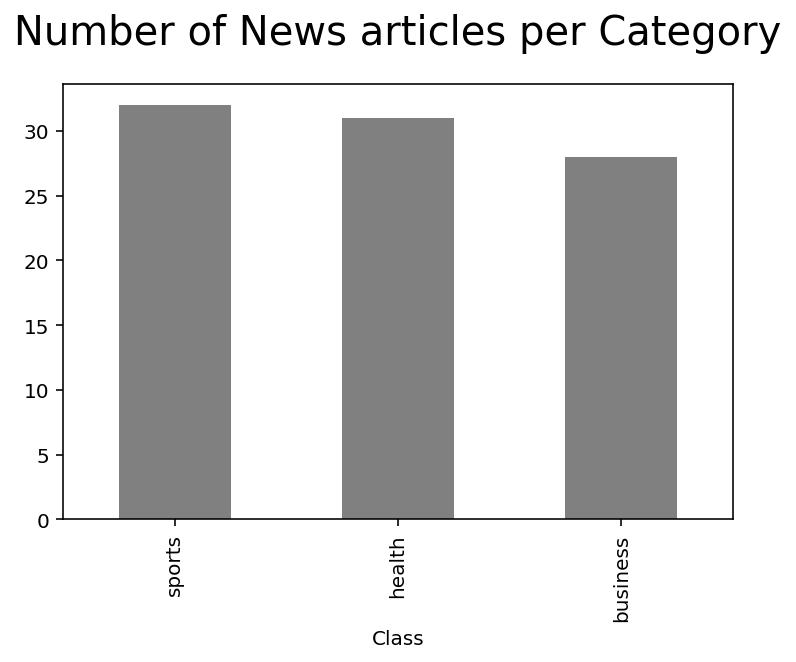

In [6]:
full_df['Class'].value_counts().plot(kind='bar', color = "grey" )
plt.title('Number of News articles per Category', size=20, pad=20);

In [7]:
# Check for missing values
full_df.isna().sum()

Text     0
Class    0
dtype: int64

## 2. Preprocessing


In [8]:
def preprocess(df):
    # Remove special characters
    df['Text2'] = df['Text'].replace('\n',' ')
    df['Text2'] = df['Text2'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df['Text2'] = df['Text2'].str.lower()
    df['Text2'] = df['Text2'].str.translate(str.maketrans('', '', string.punctuation))
    
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    
    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df['Text2'] = df['Text2'].apply(lematize)

In [9]:
preprocess(full_df)

### Preprocessing sampel

**Processed:**

In [10]:
full_df.iloc[1]['Text2']

'gold price fall grey metal shine himalayan news service publish jul file photofile photo kathmandu july price yellow metal decrease silver increase trading week june domestic market gold price decrease r per tola silver price rise r tola review weekaccording rate list federation nepal gold silver dealer association fene gosida gold price fix r per tola market open trading sunday gold price increase r tola monday increase r per tola r tola tuesday price yellow metal decrease r per tola wednesday decrease r tola thursdayon friday gold price rise r per tola close trading week r tolameanwhile silver trade r per tola sunday increase r tola monday price grey metal increase r per tola tuesday remain unchanged next day price fell five rupee tola thursday fall r per tola friday settle r tola weekaccording international news agency gold bound first quarterly decline three squeeze expectation u interest rate hike moderate inflation print provide support fridayprices shed per cent quarter drop le

## 3. Training -  Testing - Splitting of Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(full_df['Text2'], 
                                                    full_df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=9)

#### Check for acceptable category balance

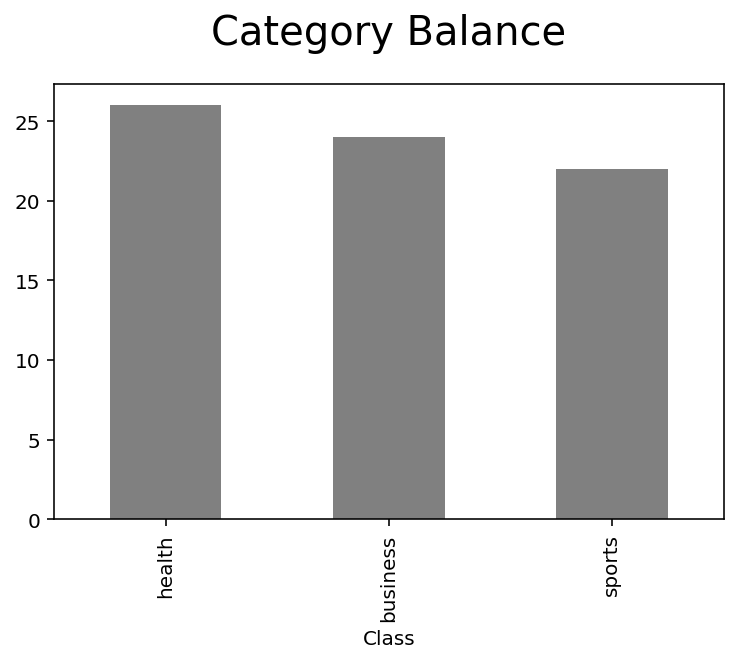

In [12]:
y_train.value_counts().plot(kind='bar', color = "grey")
plt.title('Category Balance', size=20, pad=20);

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72,) (19,) (72,) (19,)


## 4.  Vectorize

In [14]:
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

## 5.  Construct Model

In [15]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    return output

In [16]:
dectree = fit_model(DecisionTreeClassifier(), 'DTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NB')

dt = pd.DataFrame.from_dict(dectree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

In [17]:
l1 = [bc, rc, dt]
l2 =["NB", "Ridge", "DT"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [18]:
dectree

{'fit_time': array([0.05581522, 0.0251348 , 0.02578092]),
 'score_time': array([0.01029611, 0.00895786, 0.0082252 ]),
 'test_accuracy': array([0.54166667, 0.75      , 0.70833333]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.53472222, 0.74861111, 0.69444444]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.63333333, 0.76363636, 0.69978632]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.54166667, 0.75      , 0.70833333]),
 'train_recall_weighted': array([1., 1., 1.])}

In [19]:
ridge

{'fit_time': array([0.03392315, 0.02645206, 0.02761102]),
 'score_time': array([0.00709605, 0.00887203, 0.00818515]),
 'test_accuracy': array([0.83333333, 0.95833333, 0.95833333]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.84027778, 0.95795626, 0.95856676]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.89393939, 0.96296296, 0.96296296]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.83333333, 0.95833333, 0.95833333]),
 'train_recall_weighted': array([1., 1., 1.])}

In [20]:
bayes

{'fit_time': array([0.02824211, 0.02377009, 0.02484679]),
 'score_time': array([0.0068171 , 0.00878477, 0.00817394]),
 'test_accuracy': array([0.83333333, 0.91666667, 0.91666667]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.83921988, 0.91846824, 0.91712963]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.89393939, 0.93333333, 0.93333333]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.83333333, 0.91666667, 0.91666667]),
 'train_recall_weighted': array([1., 1., 1.])}

In [21]:
relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = joined_output.loc[joined_output.model == 'DT'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NB'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

#### Decision Tree metrics

In [22]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.541667,0.633333,0.541667,0.534722
1,0.750000,0.763636,0.750000,0.748611
2,0.708333,0.699786,0.708333,0.694444


#### Multinomial Naive Bayes metrics

In [23]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.833333,0.893939,0.833333,0.839220
1,0.916667,0.933333,0.916667,0.918468
2,0.916667,0.933333,0.916667,0.917130


#### Ridge Classifier metrics

In [24]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.833333,0.893939,0.833333,0.840278
1,0.958333,0.962963,0.958333,0.957956
2,0.958333,0.962963,0.958333,0.958567


#### Average metrics

In [25]:
metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, namess in zip(metrics_, names_):
    print(f'{namess} Mean Metrics:')
    print(scores.mean())
    print('  ')

Decision Tree Mean Metrics:
test_accuracy              0.666667
test_precision_weighted    0.698919
test_recall_weighted       0.666667
test_f1_weighted           0.659259
dtype: float64
  
Naive Bayes Mean Metrics:
test_accuracy              0.888889
test_precision_weighted    0.920202
test_recall_weighted       0.888889
test_f1_weighted           0.891606
dtype: float64
  
Ridge Classifier Mean Metrics:
test_accuracy              0.916667
test_precision_weighted    0.939955
test_recall_weighted       0.916667
test_f1_weighted           0.918934
dtype: float64
  


### Choosing Best Model 

Through the above calculations Ridge Classifier Method has the highest accuracy as it is able to give probabibility score for each prediction.

In [26]:
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

In [27]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

In [28]:
# Create model
CLASSYfier = create_and_fit(MultinomialNB(), X, y)

In [29]:
CLASSYfier.classes_

array(['business', 'health', 'sports'], dtype='<U8')

## FINAL TESTING

The text given is related more towards the business articles of daily newspapers, hence should classify as business category.



In [30]:
input_text = '(Reuters) -Gold Prices are going up'
CLASSYfier.predict_proba([input_text])

array([[0.42105645, 0.27927636, 0.29966719]])

In [31]:
CLASSYfier.predict([input_text])[0]

'business'

## GUI

In [32]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText


window = tk.Tk()


window.title("TEXT CLASSIFICATION")
window.minsize(600,390)
window.configure(bg='#D3D3D3')


text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    BUSINESS = round(pr[0][0], 3)
    HEALTH = round(pr[0][1], 3)
    SPORTS = round(pr[0][2], 3)
    
    lines = [f"Business: {BUSINESS}", f"Health: {HEALTH}", f"Sports: {SPORTS}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    

def classify_text(input_text):
    out = CLASSYfier.predict([input_text])[0]
    probs = CLASSYfier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Enter the text", bg = "#D3D3D3", font = ("Calibri", 13, "bold"))
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Classify", bg = "#D3D3D3", font = ("Calibri", 11, "bold"), command=clickMe)
btn.grid(column=0, row=2)

window.mainloop()